Continut /kaggle/input:
  - dataset

Continut /kaggle/input/dataset:
  - dev.csv
  - README.md
  - train_s.csv
  - train_xl.csv
  - .gitattributes
  - train.csv
  - test.csv

Train small: (200, 5)
Dev: (1094, 5)
Primele 3 randuri din train_s:
                                         startphrase  \
0                The future is as bright as the sun   
1                    The future is as bright as ink   
2  She thinks of herself as the mother of humanity.   

                               ending1  \
0                 The future is bright   
1                 The future is bright   
2  She is self-righteous and entitled.   

                                             ending2  labels  valid  
0                           The future is not bright       0      1  
1                           The future is not bright       1      1  
2  She is humble and respectful towards the diffe...       0      1   



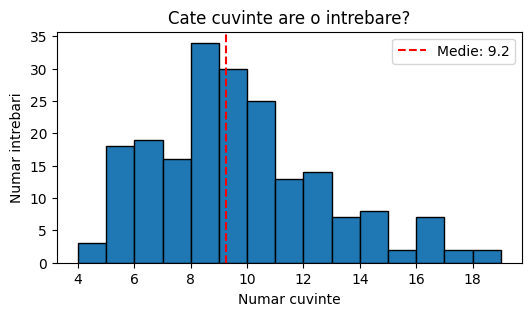

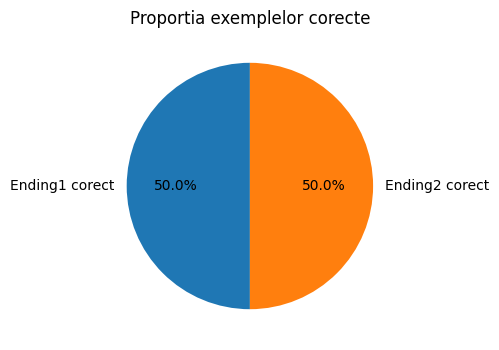

Numar exemple: {0: 100, 1: 100} 

Baseline Accuracy pe dev: 50.32%
              precision    recall  f1-score   support

      gresit       0.50      0.56      0.53      1094
      corect       0.50      0.45      0.48      1094

    accuracy                           0.50      2188
   macro avg       0.50      0.50      0.50      2188
weighted avg       0.50      0.50      0.50      2188


GridSearch Best params: {'clf__C': 0.1, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}
Best CV accuracy: 15.74%

Word+Char Accuracy pe dev: 50.00%
              precision    recall  f1-score   support

      gresit       0.50      0.53      0.52      1094
      corect       0.50      0.47      0.48      1094

    accuracy                           0.50      2188
   macro avg       0.50      0.50      0.50      2188
weighted avg       0.50      0.50      0.50      2188


✅ Fisier salvat: /kaggle/working/resultate_test.csv

Continut /kaggle/working:
  - metaphor_results.csv
  - resultate_

In [21]:
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
from itertools import islice
from glob import glob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# FCT UTILITARE
# fct pt listarea fisierelor dintr-un director
def list_directory(path):
    print(f"Continut {path}:")
    for f in os.listdir(path):
        print("  -", f)
    print()

# INCARCARE DATE

INPUT_DIR = "/kaggle/input"
DATA_DIR  = f"{INPUT_DIR}/dataset"

# afisam continutul directoarelor relevante
list_directory(INPUT_DIR)
list_directory(DATA_DIR)

# citim fisierele de date in DataFrame-uri
df_train_small = pd.read_csv(f"{DATA_DIR}/train_s.csv") # train_s.csv: subset mic pt antrenament rapid
df_dev         = pd.read_csv(f"{DATA_DIR}/dev.csv") # dev.csv: set de validare
df_test        = pd.read_csv(f"{DATA_DIR}/test.csv") # test.csv: set pentru predicții finale

# EXPLORARE DATE (EDA)
# afisam dimensiunile seturilor de date si primele randuri
print("Train small:", df_train_small.shape)
print("Dev:", df_dev.shape)
print("Primele 3 randuri din train_s:\n", df_train_small.head(3), "\n")

# histograma a lungimii intrebarilor (nr de cuvinte)
lungimi = df_train_small['startphrase'].astype(str).map(lambda t: len(t.split()))
plt.figure(figsize=(6,3))
plt.hist(lungimi, bins=15, edgecolor='black')
plt.title('Cate cuvinte are o intrebare?')
plt.xlabel('Numar cuvinte')
plt.ylabel('Numar intrebari')
plt.axvline(lungimi.mean(), color='red', linestyle='--', label=f'Medie: {lungimi.mean():.1f}')
plt.legend()
plt.show()

# diagrama circulara a proportiei etichetelor de training
cnt = df_train_small['labels'].value_counts().sort_index()
plt.figure(figsize=(4,4))
plt.pie(cnt, labels=['Ending1 corect','Ending2 corect'], autopct='%1.1f%%', startangle=90)
plt.title('Proportia exemplelor corecte')
plt.show()
print("Numar exemple:", cnt.to_dict(), "\n")

# PREGATIREA DATELOR PT MODEL
# fct pt transformarea fiecarei intrebari in doua exemple de text + etichete
def build_examples(df):
    """
    construieste exemple de text si etichete pt model:
      - concatenate startphrase + fiecare final
      - eticheta 1 pt varianta corecta, 0 pentru cea gresita
    """
    texts, labels = [], []
    for _, r in df.iterrows():
        q, a, b, lbl = r['startphrase'], r['ending1'], r['ending2'], r['labels']
        # adaugam varianta A si eticheta corespunzatoare
        texts.append(q + " " + str(a)); labels.append(1 if lbl==0 else 0)
        # adaugam varianta B si eticheta corespunzatoare
        texts.append(q + " " + str(b)); labels.append(1 if lbl==1 else 0)
    return texts, labels

texts_train, labels_train = build_examples(df_train_small)
texts_dev,   labels_dev   = build_examples(df_dev)

# MODEL DE BAZA: TF-IDF + Logistic Regression
# vectorizare TF-IDF pt un nr limitat de caracteristici (max_features)
vect       = TfidfVectorizer(max_features=5000)
X_train    = vect.fit_transform(texts_train)
# antrenam un classifier logistic cu max_iter pt convergenta
clf_base   = LogisticRegression(max_iter=1000).fit(X_train, labels_train)

# evaluam performanta pe setul de validare (dev)
X_dev      = vect.transform(texts_dev)
pred_dev   = clf_base.predict(X_dev)
acc_base   = accuracy_score(labels_dev, pred_dev)

print(f"Baseline Accuracy pe dev: {acc_base:.2%}")
print(classification_report(labels_dev, pred_dev, target_names=['gresit','corect']))

# GridSearch PT OPTIMIZAREA HIPERPARAMETRILOR
# definim un pipeline cu vectorizator si clasificator
pipe       = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression(solver='liblinear',max_iter=1000))])
# grid de parametri: range de ngramuri, max_features si coeficient C
param_grid = {'tfidf__ngram_range':[(1,1),(1,2)], 'tfidf__max_features':[5000,10000], 'clf__C':[0.1,1,10]}
cv         = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
gs         = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=0)
gs.fit(texts_train, labels_train)

print("\nGridSearch Best params:", gs.best_params_)
print(f"Best CV accuracy: {gs.best_score_:.2%}")

# PIPELINE MIXT: TF-IDF cu word si char n-gram
# vectorizator pt cuvinte
word_v   = TfidfVectorizer(ngram_range=(1,2), max_features=5000, analyzer='word')
# vectorizator pt caracter n-gramuri cu char_wb
char_v   = TfidfVectorizer(ngram_range=(3,5), max_features=2000, analyzer='char_wb')
# combinam cele doua vectorizatoare
union_v  = FeatureUnion([('word',word_v),('char',char_v)])
pipe_wc  = Pipeline([('vect',union_v), ('clf',LogisticRegression(C=0.1,solver='liblinear',max_iter=1000))])
# antrenam pipeline-ul mixt
pipe_wc.fit(texts_train, labels_train)
# evaluare a pipeline-ului mixt pe setul dev
pred_dev_wc = pipe_wc.predict(texts_dev)
acc_wc      = accuracy_score(labels_dev, pred_dev_wc)
print(f"\nWord+Char Accuracy pe dev: {acc_wc:.2%}")
print(classification_report(labels_dev, pred_dev_wc, target_names=['gresit','corect']))

# GGENERAREA PREDINCTIILOR
# fct pt structurarea predictiilor intr-un DataFrame
def format_test_predictions(df, vect, clf):
    """
    genereaza un DataFrame cu:
      - intrebarea originala
      - optiunile A și B
      - varianta aleasa de model
      - textul ales
    """
    rows = []
    for _, r in df.iterrows():
        q, a, b = r['startphrase'], r['ending1'], r['ending2']
        X_opts = vect.transform([q+" "+str(a), q+" "+str(b)])
        probs  = clf.predict_proba(X_opts)[:,1]
        pick   = 'A' if probs[0]>probs[1] else 'B'
        chosen = a if pick=='A' else b
        rows.append({
            'Intrebare': q,
            'Optiune A': a,
            'Optiune B': b,
            'Model a ales': pick,
            'Text ales': chosen
        })
    return pd.DataFrame(rows)

# aplicam fct pt setul de test
df_test_friendly = format_test_predictions(df_test, vect, clf_base)

# salvare CSV

output_path = '/kaggle/working/resultate_test.csv'
df_test_friendly.to_csv(
    output_path,
    index=False,
    sep=';', # separator punct-virgula
    quoting=csv.QUOTE_ALL # toate campurile intre ghilimele
)
print(f"\n✅ Fisier salvat: {output_path}")

# confirmare in /kaggle/working
print("\nContinut /kaggle/working:")
for f in os.listdir('/kaggle/working'):
    print("  -", f)

# preview primele 10 randuri
print("\n=== Preview primele 10 predictii ===")
print(df_test_friendly.head(10))